# Continuous least squares: from the Hilbert matrix to Legendre polynomials

In this notebook we will study continuous least squares approximation via monomials and orthogonal polynomials.

For more details, see Chapter 16 of 

*Q. Kong, T. Siauw, and A. M. Bayen. Python Programming and Numerical Methods: A Guide for Engineers and Scientists. Academic Press, 2021. (https://pythonnumericalmethods.berkeley.edu/)*

and Section 8.2 of

*Richard L. Burden, J. Douglas Faires and Annette M. Burden. Numerical Analysis (10th Edition). Cengage, 2016.*

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

## Continuous least squares

Let $\{\phi_0(x), \ldots, \phi_n(x)\}$ be a basis for the space $\Pi_n$ of polynomilas of degree at most $n$. Recall that a continuous least squares polynomial approximation to a function $f$ over an interval $[a,b]$ is found by computing a polynomial
$$
P_n(x) = \sum_{k = 0}^n c_k \phi_k(x)
$$
that minimizes the *$L^2$ approximation error*
$$
E(c) = \int_a^b \bigg(f(x) - \sum_{k = 0}^n c_k \phi_k(x)\bigg)^2 dx.
$$
The function $E(c)$ has a unique minimizer over $\mathbb{R}^{n+1}$, satisfying the $(n+1) \times (n+1)$ linear system of *normal equations* $M c = b$, where
$$
M_{i j} = \int_a^b \phi_i(x)\phi_j(x) dx\quad \text{and} \quad b_i = \int_a^b f(x) \phi_i(x), \quad \forall i,j = 0, \ldots, n.
$$

## Ill conditioning of the monomial basis and the Hilbert matrix

When using the monomial basis $\phi_k(x) = x^k$, the entries of the normal equations matrix are explicitly computable:
$$
M_{i j} = \int_a^b x^{i+j} dx = \frac{b^{i+j+1}- a^{i+j+1}}{i+j+1}, \quad \forall i,j  = 0,\ldots, n.
$$
When $[a,b] = [0,1]$ this leads to the *Hilbert matrix* $M = H$, where
$$
H_{ij} = \frac{1}{i+j+1}, \quad \forall i,j  = 0,\ldots, n.
$$
$H$ is an example of *ill conditioned matrix*, i.e. having a really large ratio between its largest and smallest singular values. The condition number of a matrix can be computed using the command `np.linalg.cond`. An optimally well-conditioned matrix is the identity, with a condition number equal to 1. A condition number much larger than 1 measn that the matrix is ill-conditioned and that accurately solving linear systems associated with it is challenging or nearly impossible. (For more info, see https://en.wikipedia.org/wiki/Condition_number#Matrices and Section 7.5 of *Richard L. Burden, J. Douglas Faires and Annette M. Burden. Numerical Analysis (10th Edition). Cengage, 2016.*).

This makes performing numerical computations with $H$ very challenging. In double precision arithmetic, its determinant $\det(H) \approx 2^{-2n^2}$ is numerically $0$ for $n \geq 12$. This means that the matrix is numerically singular for moderate values of $n$. See also http://nhigham.com/2020/06/30/what-is-the-hilbert-matrix/ . 

Let's start by  plotting the condition number of $H$ as a functio of $n$.

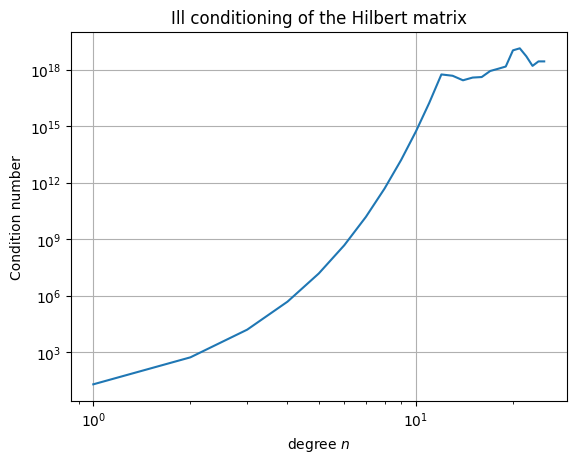

In [2]:
n_max = 25 # maximum degree n

# Compute Hilbert matrix
H = np.zeros((n_max,n_max))
for i in range(n_max):
    H[i,i] = 1/(2*i+1)
    for j in range(i+1,n_max):
        H[i,j] = 1/(i+j+1)
        H[j,i] = H[i,j]

cond_H_vals = np.array([], dtype=np.int64).reshape(0,1) # initialize array of condition numbers
n_vals = np.arange(n_max)+1 # values of n

# compute condition numbers
for n in n_vals:
    cond_H_vals = np.vstack((cond_H_vals, np.linalg.cond(H[0:n+1, 0:n+1])))

# Visualize results
plt.loglog(n_vals, cond_H_vals)
plt.xlabel('degree $n$')
plt.ylabel('Condition number')
plt.title('Ill conditioning of the Hilbert matrix')
plt.grid()
plt.show()

## Example using monomials

We want to approximate the function $f(x) = e^x$ in $[0,1]$ with continuous least squares using the monomial basis. The integrals of the right-hand side of the system of normal equations are recursively defined as
$$
b_0 = \int_0^1 e^x dx = e-1, \quad b_i = \int_0^1 x^k e^x dx = e - i b_{i-1}, \quad  \forall i =1, \ldots, n.
$$
(Check this!). Let's compute the continuous least squares approximation for different values of $n$.

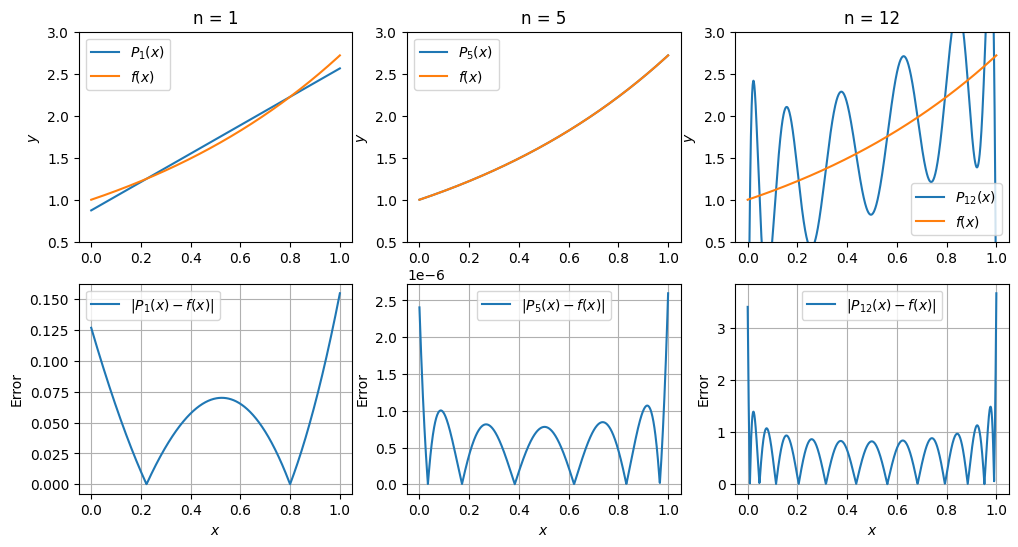

In [3]:
f = lambda x: np.exp(x) 

# create function that evaluates polynomial with given coefficients 
def poly_eval_monomial(coeff, x):
    y = x * 0;
    for k in np.arange(len(coeff)):
        y = y + coeff[k] * x**k
    return y


# array of n values
n_values = np.array((1, 5, 12))

# Create right hand-side for largest value of n
b_large = np.zeros((max(n_values)+1,1))
b_large[0] = math.e - 1
for i in np.arange(1,max(n_values)+1):
    b_large[i] = math.e - i * b_large [i-1]


# dset up visualization
plt.figure(figsize = (12, 6) )
x_grid = np.linspace(0,1,1000)

# construct continuous least squares approximations for different values of n
i_n = 0
for n in n_values:
    i_n += 1
    
    # create and solve linear system of normal equations
    b = b_large[0:n+1]
    M = H[0:n+1, 0:n+1]
    c = np.linalg.solve(M,b)

    # visualize results
    plt.subplot(2, 3, i_n)
    plt.plot(x_grid, poly_eval_monomial(c, x_grid), label = '$P_{'+str(n)+'}(x)$' )
    plt.plot(x_grid, f(x_grid), label = '$f(x)$')
    plt.ylabel('$y$')
    plt.ylim([0.5,3])
    plt.title('n = '+str(n))
    plt.legend()

    # visualize error
    plt.subplot(2, 3, i_n+3)
    plt.plot(x_grid, np.abs(poly_eval_monomial(c, x_grid) - f(x_grid)), label = '$|P_{'+str(n)+'}(x) - f(x)|$' )
    plt.ylabel('Error')
    plt.xlabel('$x$')
    plt.grid()
    plt.legend()
    
plt.show()

As expected, for $n=12$ the approximation is very poor! This is due to the ill conditioning of the Hilbert matrix and the resulting impossibility to solve the linear system of normal equations. Hence, continuous least squares approximations computed with the monomial basis can be highly *unstable*.

## Legendre polynomials

This issue is solved by resorting to orthogonal polynomials. Orthogonal polynomials over $[-1,1]$ (with respect to the standard weight $w(x)=1$) are the *Legendre polynomials* $L_0(x), \ldots, L_n(x)$ . One way to define them is through the three-term recurrence relation
$$
 n L_{k}(x) = (2k-1) x L_{k-1}(x) - (k-1) L_{k-2}(x), \quad \forall k \geq 2
$$
with $L_0(x) = 1$ and $L_1(x) = x$ (see https://en.wikipedia.org/wiki/Legendre_polynomials). This is easily implementable in Python through a recursive function.

In [4]:
def Legendre(k,x):
    """
    Implementation of Legedre polynomials based on their three-term recurrence relation
    """
    if k == 0:
        return x * 0 + 1 # trick to make sure that this output is vectorized: return 1 would yield a scalar as output
    elif k == 1:
        return x
    else:
        return ((2*k - 1)* x * Legendre(k-1,x) - (k-1) * Legendre(k-2,x))/ k

Let's visualize the first few Legendre polynomials.

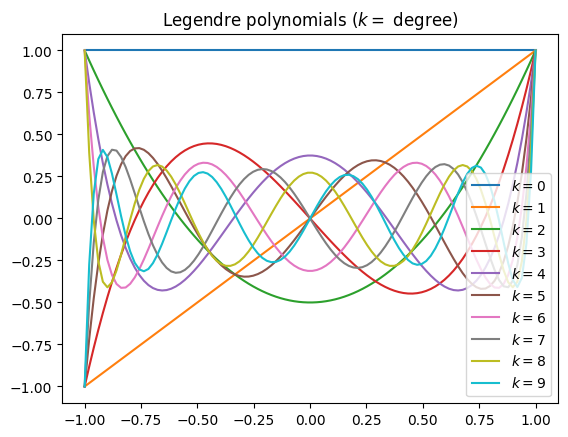

In [5]:
x_grid = np.linspace(-1,1,100)

for k in np.arange(10):
    plt.plot(x_grid, Legendre(k,x_grid), label = '$k = '+str(k)+'$')

plt.title('Legendre polynomials ($k = $ degree)')
plt.legend()
plt.show()

## Computing least squares approximations with Legendre polynomials

With this recurrent relation, Legendre polynomials are standardized so to have $P_k(1)=1$ for every $k \geq 0$. Moreover, it is possible to show that 
$$
\int_{-1}^1 L_i(x) L_j(x) dx = \frac{2}{2i+1}\delta_{i,j}.
$$
To work on the interval $[0,1]$ like in the previous example, we make a change of variable $x\mapsto 2x-1$ and consider polynomials $\phi_k (x) = L_k(2x-1)$. The corresponding linear system of normal equations $M c = b$ is associated with a *diagonal* matrix $M$ defined by
$$
M_{ij} = \int_{0}^1 L_i(2x-1) L_j(2x-1) dx = \frac 12 \int_{-1}^1 L_i(x) L_j(x) dx = \frac{1}{2i+1}\delta_{i,j}.
$$
This linear system can be directly solved without resorting to a numerical solver, with the direct formula
$$
c_i = M_{ii}^{-1} b_i = (2i+1)\int_{0}^1 f(x) L_i(2x-1) dx, \quad \forall i =0, \ldots, n.
$$
Of course, to solve the problem one needs to compute these integrals. For now, we will use the built-in function `quad` from the `scipy.intregrate` module. In an upcoming notebook, we will study more in depth how to numerically approximate such integrals using *quadrature formulas*. 

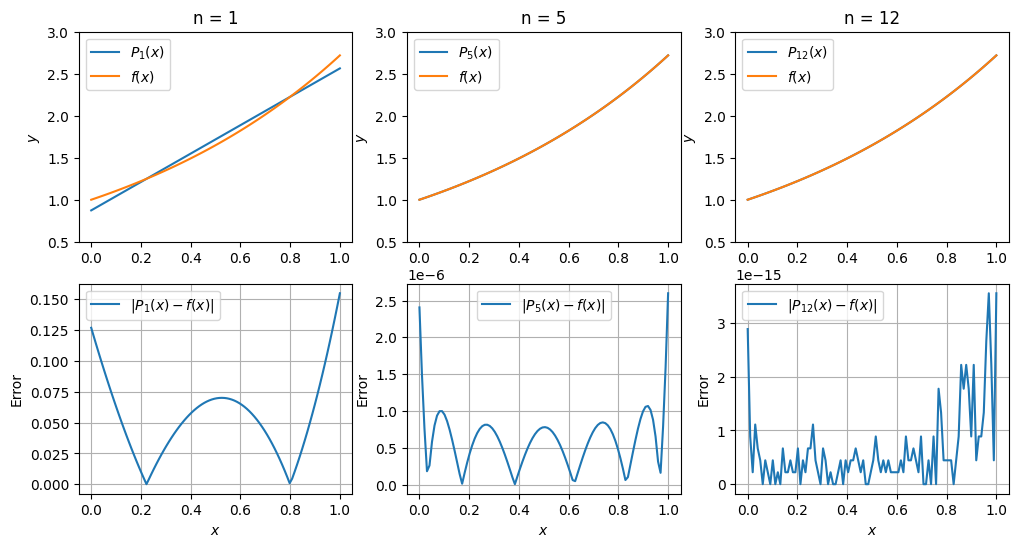

In [6]:
from scipy.integrate import quad 

# function needed to evaluate a linear combination of Legendre polynomials
def poly_eval_legendre(coeff, x):
    y = x * 0;
    for k in np.arange(len(coeff)):
        y = y + coeff[k] * Legendre(k,x)
    return y

# array of n values
n_values = np.array((1, 5, 12))

# Create right hand-side for largest value of n
b = np.zeros((max(n_values)+1,1))
for i in np.arange(max(n_values)+1):
    integral, error = quad(lambda x: Legendre(i,2*x-1) * f(x), 0, 1)
    b[i] = integral

# dset up visualization
plt.figure(figsize = (12, 6) )
x_grid = np.linspace(0,1,100)

# construct continuous least squares approximations for different values of n
i_n = 0
for n in n_values:
    i_n += 1
    
    # Solve diagonal system of normal equations
    c = np.zeros((n+1,1))
    for i in np.arange(n+1):
        c[i] = b[i] * (2*i + 1)

    # visualize results
    plt.subplot(2, 3, i_n)
    plt.plot(x_grid, poly_eval_legendre(c, 2*x_grid-1), label = '$P_{'+str(n)+'}(x)$' )
    plt.plot(x_grid, f(x_grid), label = '$f(x)$')
    plt.ylabel('$y$')
    plt.ylim([0.5,3])
    plt.title('n = '+str(n))
    plt.legend()

    # visualize error
    plt.subplot(2, 3, i_n+3)
    plt.plot(x_grid, np.abs(poly_eval_legendre(c, 2*x_grid-1) - f(x_grid)), label = '$|P_{'+str(n)+'}(x) - f(x)|$' )
    plt.ylabel('Error')
    plt.xlabel('$x$')
    plt.grid()
    plt.legend()
    
plt.show()

The results are now perfectly stable using Legendre polynomials.

## Recommended problems

- Compare monomials and Legendre polynomials for the approximation of the function $f(x) = \exp(x^2)$ over $[0,1]$. Use the function `quad` from the `scipy.integrate` module to compute integrals when needed.

- Similarly to what we did for Legendre polynomials, implement Chebyshev polynomials $T_k(x)$ and visualize them using thei three-term recurrence relationship (see https://en.wikipedia.org/wiki/Chebyshev_polynomials). Compare your results with those obtained using the explicit formula $T_k(x) = \cos(k \arccos(x))$